In [1]:
import gurobipy as gp
from gurobipy import GRB
import SystemCharacteristics as data
import PlotsRestaurant
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fixed_data = data.get_fixed_data()
fixed_data.keys()

dict_keys(['num_timeslots', 'initial_temperature', 'previous_initial_temperature', 'initial_humidity', 'heating_max_power', 'heat_exchange_coeff', 'heating_efficiency_coeff', 'thermal_loss_coeff', 'heat_vent_coeff', 'heat_occupancy_coeff', 'temp_min_comfort_threshold', 'temp_OK_threshold', 'temp_max_comfort_threshold', 'outdoor_temperature', 'vent_min_up_time', 'humidity_threshold', 'ventilation_power', 'humidity_occupancy_coeff', 'humidity_vent_coeff'])

In [3]:
row_nr = 0

# Load Data from CSVs as requested
price = pd.read_csv('PriceData.csv').iloc[row_nr, :].tolist()
Occ_r1 = pd.read_csv('OccupancyRoom1.csv').iloc[row_nr, :].tolist()
Occ_r2 = pd.read_csv('OccupancyRoom2.csv').iloc[row_nr, :].tolist()

# Define T based on fixed_data
T = fixed_data['num_timeslots']
T_range = range(T)  # Time indices from 1 to T
R = [0, 1]  # Room indices (Room 1 and Room 2)
M = 60

# Initialize Model
model = gp.Model("Restaurant_Energy_Optimization")

# --- Decision Variables ---
# Temperature in room 1 and 2 [cite: 16, 49, 59]
Temp_r1 = model.addVars(T, lb=-GRB.INFINITY, name="Temp_r1")
Temp_r2 = model.addVars(T, lb=-GRB.INFINITY, name="Temp_r2")

# Heater power consumption for room 1 and 2 [cite: 14, 53, 79]
h_r1 = model.addVars(T, lb=0, ub=fixed_data['heating_max_power'], name="h_r1")
h_r2 = model.addVars(T, lb=0, ub=fixed_data['heating_max_power'], name="h_r2")

# Ventilation status (Binary) [cite: 13, 60, 80]
v = model.addVars(T, vtype=GRB.BINARY, name="v")

# Humidity [cite: 17, 47, 58]
Hum = model.addVars(T, lb=0, ub=100, name="Hum")

# Auxiliary variables for constraints (Inertia, Overrules) [cite: 18, 51, 61]
s = model.addVars(T, vtype=GRB.BINARY, name="s") # Start-up variable for ventilation
z_low = model.addVars(R, T, vtype=GRB.BINARY, name="z_low") # Low temp overrule
z_high = model.addVars(R, T, vtype=GRB.BINARY, name="z_high") # High temp overrule

# [cite_start]--- 5. Initial Conditions [cite: 46, 48, 54] ---
model.addConstr(Temp_r1[0] == fixed_data['initial_temperature'], name="init_temp_r1")
model.addConstr(Temp_r2[0] == fixed_data['initial_temperature'], name="init_temp_r2")
model.addConstr(Hum[0] == fixed_data['initial_humidity'], name="init_hum")

# [cite_start]--- 6. Objective Function [cite: 43] ---
model.setObjective(
    gp.quicksum(
        (fixed_data['ventilation_power'] * v[t] + h_r1[t] + h_r2[t]) * price[t] 
        for t in T_range
    ), GRB.MINIMIZE
)

# --- 7. Constraints ---

# [cite_start]Humidity Dynamics [cite: 47]
model.addConstrs((Hum[t] == Hum[t-1] + fixed_data['humidity_occupancy_coeff'] * (Occ_r1[t-1] + Occ_r2[t-1]) - 
                  fixed_data['humidity_vent_coeff'] * v[t-1] for t in range(1,T)), name="Hum_Dynamics")

# [cite_start]Temperature Dynamics Room 1 [cite: 49]
model.addConstrs((Temp_r1[t] == Temp_r1[t-1] + fixed_data['heat_exchange_coeff'] * (Temp_r2[t-1] - Temp_r1[t-1]) +
                  fixed_data['thermal_loss_coeff'] * (fixed_data['outdoor_temperature'][t-1] - Temp_r1[t-1]) +
                  fixed_data['heating_efficiency_coeff'] * h_r1[t] - fixed_data['heat_vent_coeff'] * v[t] + 
                  fixed_data['heat_occupancy_coeff'] * Occ_r1[t-1] for t in range(1,T)), name="Temp_Dynamics_R1")

# [cite_start]Temperature Dynamics Room 2 [cite: 49]
model.addConstrs((Temp_r2[t] == Temp_r2[t-1] + fixed_data['heat_exchange_coeff'] * (Temp_r1[t-1] - Temp_r2[t-1]) +
                  fixed_data['thermal_loss_coeff'] * (fixed_data['outdoor_temperature'][t-1] - Temp_r2[t-1]) +
                  fixed_data['heating_efficiency_coeff'] * h_r2[t] - fixed_data['heat_vent_coeff'] * v[t] + 
                  fixed_data['heat_occupancy_coeff'] * Occ_r2[t-1] for t in range(1,T)), name="Temp_Dynamics_R2")

# [cite_start]Low-temperature overrule [cite: 51, 53]
model.addConstrs((fixed_data['temp_min_comfort_threshold'] - Temp_r1[t] <= M * z_low[0, t] for t in T_range), name="Low_Temp_R1_Bound")
model.addConstrs((fixed_data['temp_min_comfort_threshold'] - Temp_r2[t] <= M * z_low[1, t] for t in T_range), name="Low_Temp_R2_Bound")
model.addConstrs((h_r1[t] >= z_low[0, t] * fixed_data['heating_max_power'] for t in T_range), name="Low_Temp_R1_Power")
model.addConstrs((h_r2[t] >= z_low[1, t] * fixed_data['heating_max_power'] for t in T_range), name="Low_Temp_R2_Power")

# [cite_start]Low-temperature inertia (Only for t > 1) [cite: 51]
model.addConstrs((z_low[0, t] >= z_low[0, t-1] - 1 + (fixed_data['temp_OK_threshold'] - Temp_r1[t]) / M 
                  for t in range(1,T)), name="Low_Temp_R1_Inertia")
model.addConstrs((z_low[1, t] >= z_low[1, t-1] - 1 + (fixed_data['temp_OK_threshold'] - Temp_r2[t]) / M 
                  for t in range(1,T)), name="Low_Temp_R2_Inertia")

# [cite_start]High-temperature overrule [cite: 53]
model.addConstrs((Temp_r1[t] - fixed_data['temp_max_comfort_threshold'] <= M * z_high[0, t] for t in T_range), name="High_Temp_R1_Bound")
model.addConstrs((Temp_r2[t] - fixed_data['temp_max_comfort_threshold'] <= M * z_high[1, t] for t in T_range), name="High_Temp_R2_Bound")
model.addConstrs((h_r1[t] <= (1 - z_high[0, t]) * fixed_data['heating_max_power'] for t in T_range), name="High_Temp_R1_Power")
model.addConstrs((h_r2[t] <= (1 - z_high[1, t]) * fixed_data['heating_max_power'] for t in T_range), name="High_Temp_R2_Power")

# [cite_start]Humidity Overrule Controller [cite: 53]
model.addConstrs((Hum[t] <= fixed_data['humidity_threshold'] + M * v[t] for t in T_range), name="Hum_Overrule")

# [cite_start]Ventilation System Inertia [cite: 55, 56]
model.addConstrs((s[t] >= v[t] - v[t-1] for t in range(1,T)), name="Vent_Startup")
model.addConstrs((v[t] + v[t+1] + v[t+2] >= 3 * s[t] for t in range(T - 2)), name="Vent_Min_Up_Time")

# Solve
results = model.optimize()

Restricted license - for non-production use only - expires 2027-11-29
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 155 rows, 110 columns and 413 nonzeros (Min)
Model fingerprint: 0x8a4366a5
Model has 30 linear objective coefficients
Variable types: 50 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-02, 6e+01]
  Objective range  [3e-01, 7e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [9e-03, 7e+01]

Presolve removed 117 rows and 64 columns
Presolve time: 0.00s
Presolved: 38 rows, 46 columns, 153 nonzeros
Variable types: 36 continuous, 10 integer (10 binary)
Found heuristic solution: objective 26.0692361

Root relaxation: objective 2.069172e+01, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node  

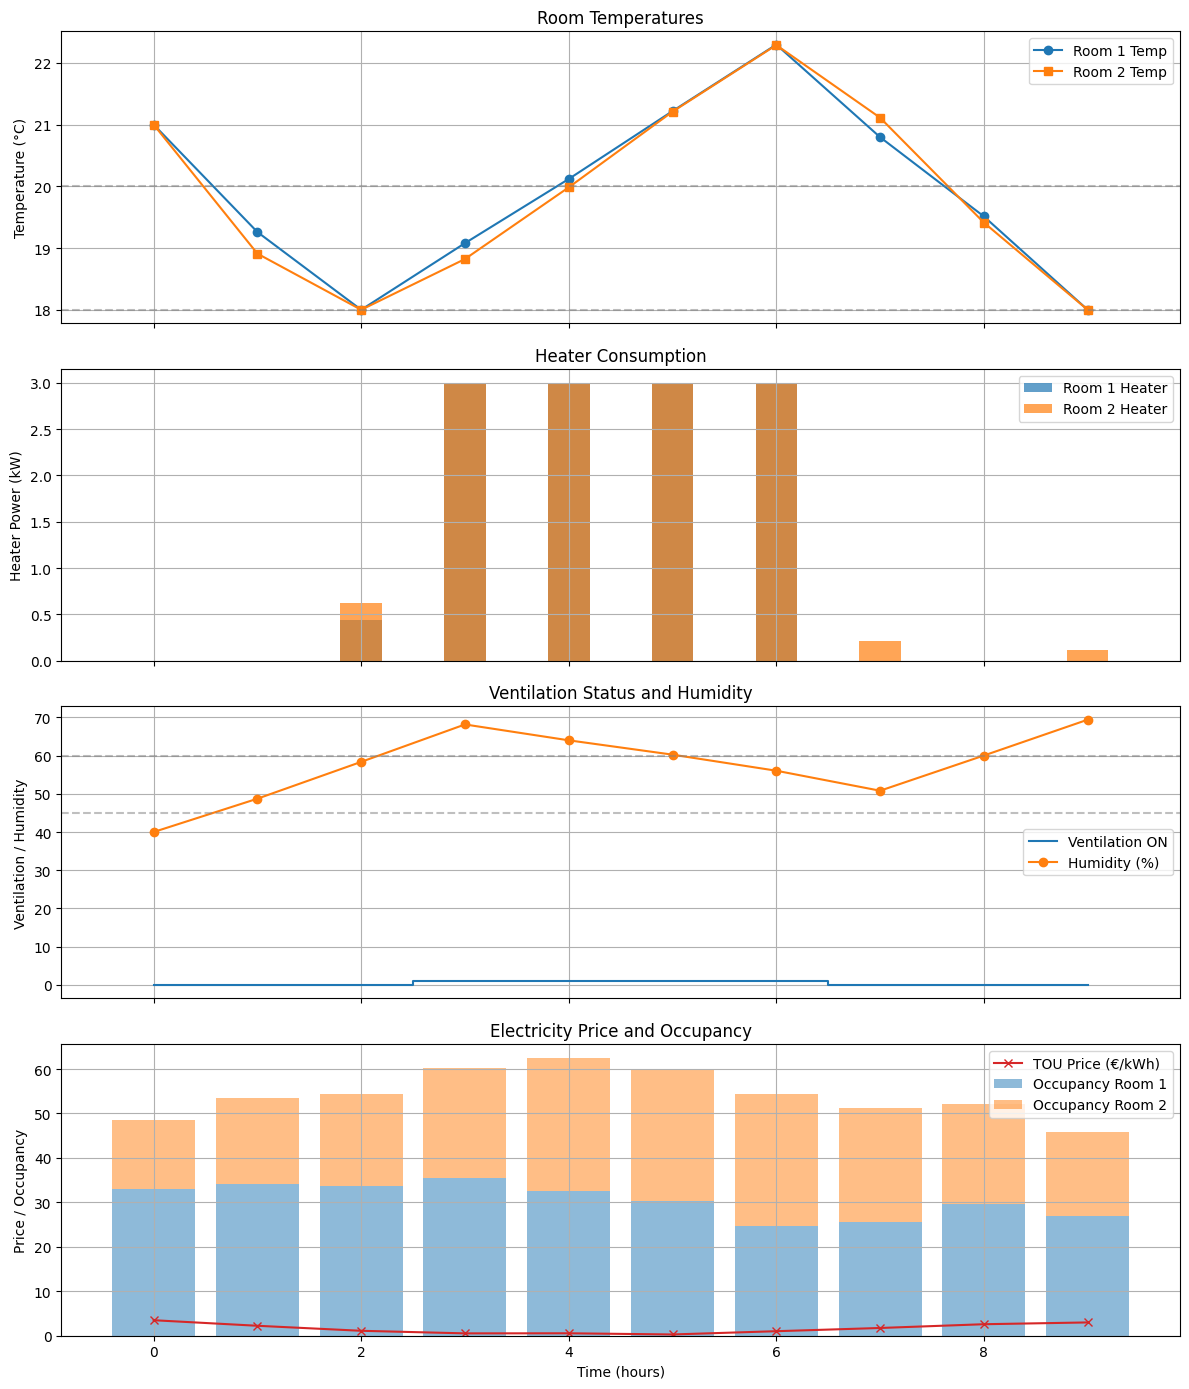

In [4]:
# --- Extract results ---
Temp_r1_vals = [Temp_r1[t].X for t in T_range]
Temp_r2_vals = [Temp_r2[t].X for t in T_range]
h_r1_vals = [h_r1[t].X for t in T_range]
h_r2_vals = [h_r2[t].X for t in T_range]
v_vals = [v[t].X for t in T_range]
Hum_vals = [Hum[t].X for t in T_range]

# --- Create dictionary for plotting ---
HVAC_results = {
    "Temp_r1": Temp_r1_vals,
    "Temp_r2": Temp_r2_vals,
    "h_r1": h_r1_vals,
    "h_r2": h_r2_vals,
    "v": v_vals,
    "Hum": Hum_vals,
    "price": price,
    "Occ_r1": Occ_r1,
    "Occ_r2": Occ_r2
}

# --- Plot results ---
# Ensure you have imported the PlotsRestaurant module, e.g., import PlotsRestaurant
PlotsRestaurant.plot_HVAC_results(HVAC_results)